In [38]:
# If you want to run this on Google Colab, just uncomment the following lines. Please note,
# that you will need to locate your folder directly in the root directory of your Google Drive (/content/drive/My Drive/).
# Because otherwise, it won't work out of the box and you would need to adjust the path in here.
#
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#
#import os
#os.chdir("/content/drive/My Drive/CSMP-Project")

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from keras import layers

2023-03-05 14:13:32.147614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 14:13:32.373532: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marc/Studium/WS22-23/Database Systems/dbsys22/build/debug/mutable/src/Mutable/lib:/usr/local/boost_1_80_0/stage/lib
2023-03-05 14:13:32.373553: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-05 14:13:33.040205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64]

In [2]:
data_file = '../../../data/unNormMar1st.csv'

dataset = pd.read_csv(data_file, sep=';')

dataset

,Size,lamdabR,lambdaS,gamma,rho,normPulloff
0,512,128,32,0.455834,4.18537,0.009895
1,1536,128,64,0.435573,1.67609,0.000039
2,1536,512,16,0.005227,3.18212,0.000133
3,1280,64,32,0.177285,3.76808,0.022324
4,2048,256,16,0.076352,2.98880,0.000205
...,...,...,...,...,...,...
244,768,768,96,0.727092,4.59056,0.001356
245,2048,512,8,0.483503,1.77412,0.000047
246,2048,128,8,0.357011,2.82643,0.019321
247,768,192,4,0.017707,3.95707,0.010177


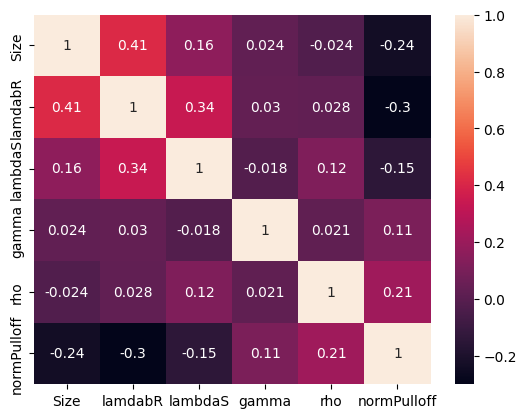

In [3]:
dataplot = sns.heatmap(dataset.corr(), cmap="rocket", annot=True)

plt.show()

In [4]:
dataset.describe()

,Size,lamdabR,lambdaS,gamma,rho,normPulloff
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,1255.325301,509.172691,95.052209,0.465411,2.633756,0.018394
std,532.167141,538.768225,197.670142,0.295416,1.309125,0.050093
min,256.000000,32.000000,4.000000,0.005227,0.125262,0.000003
25%,768.000000,128.000000,8.000000,0.201106,1.637750,0.000210
50%,1280.000000,256.000000,32.000000,0.446783,2.613690,0.000628
75%,1792.000000,768.000000,112.000000,0.716534,3.703470,0.002929
max,2048.000000,2048.000000,2048.000000,0.991867,4.993650,0.357983


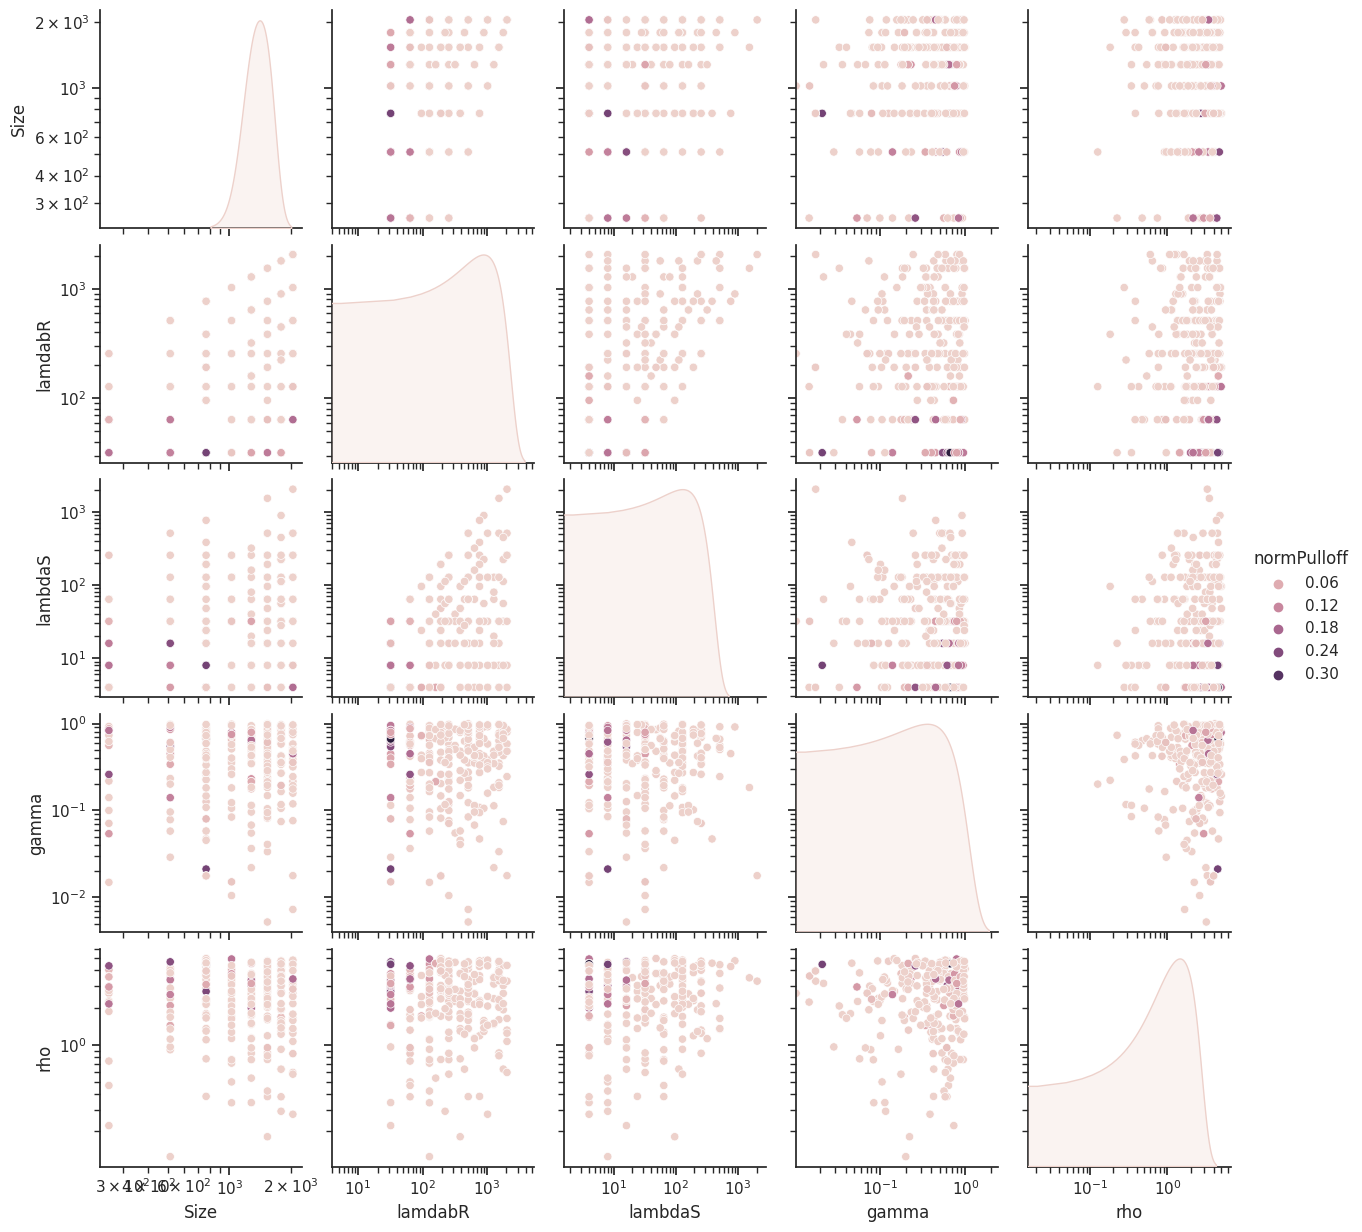

In [5]:
sns.set_theme(style="ticks")
pl = sns.pairplot(dataset, hue='normPulloff')

for ax in pl.axes.flat:
    ax.set(xscale='log')
    ax.set(yscale='log')

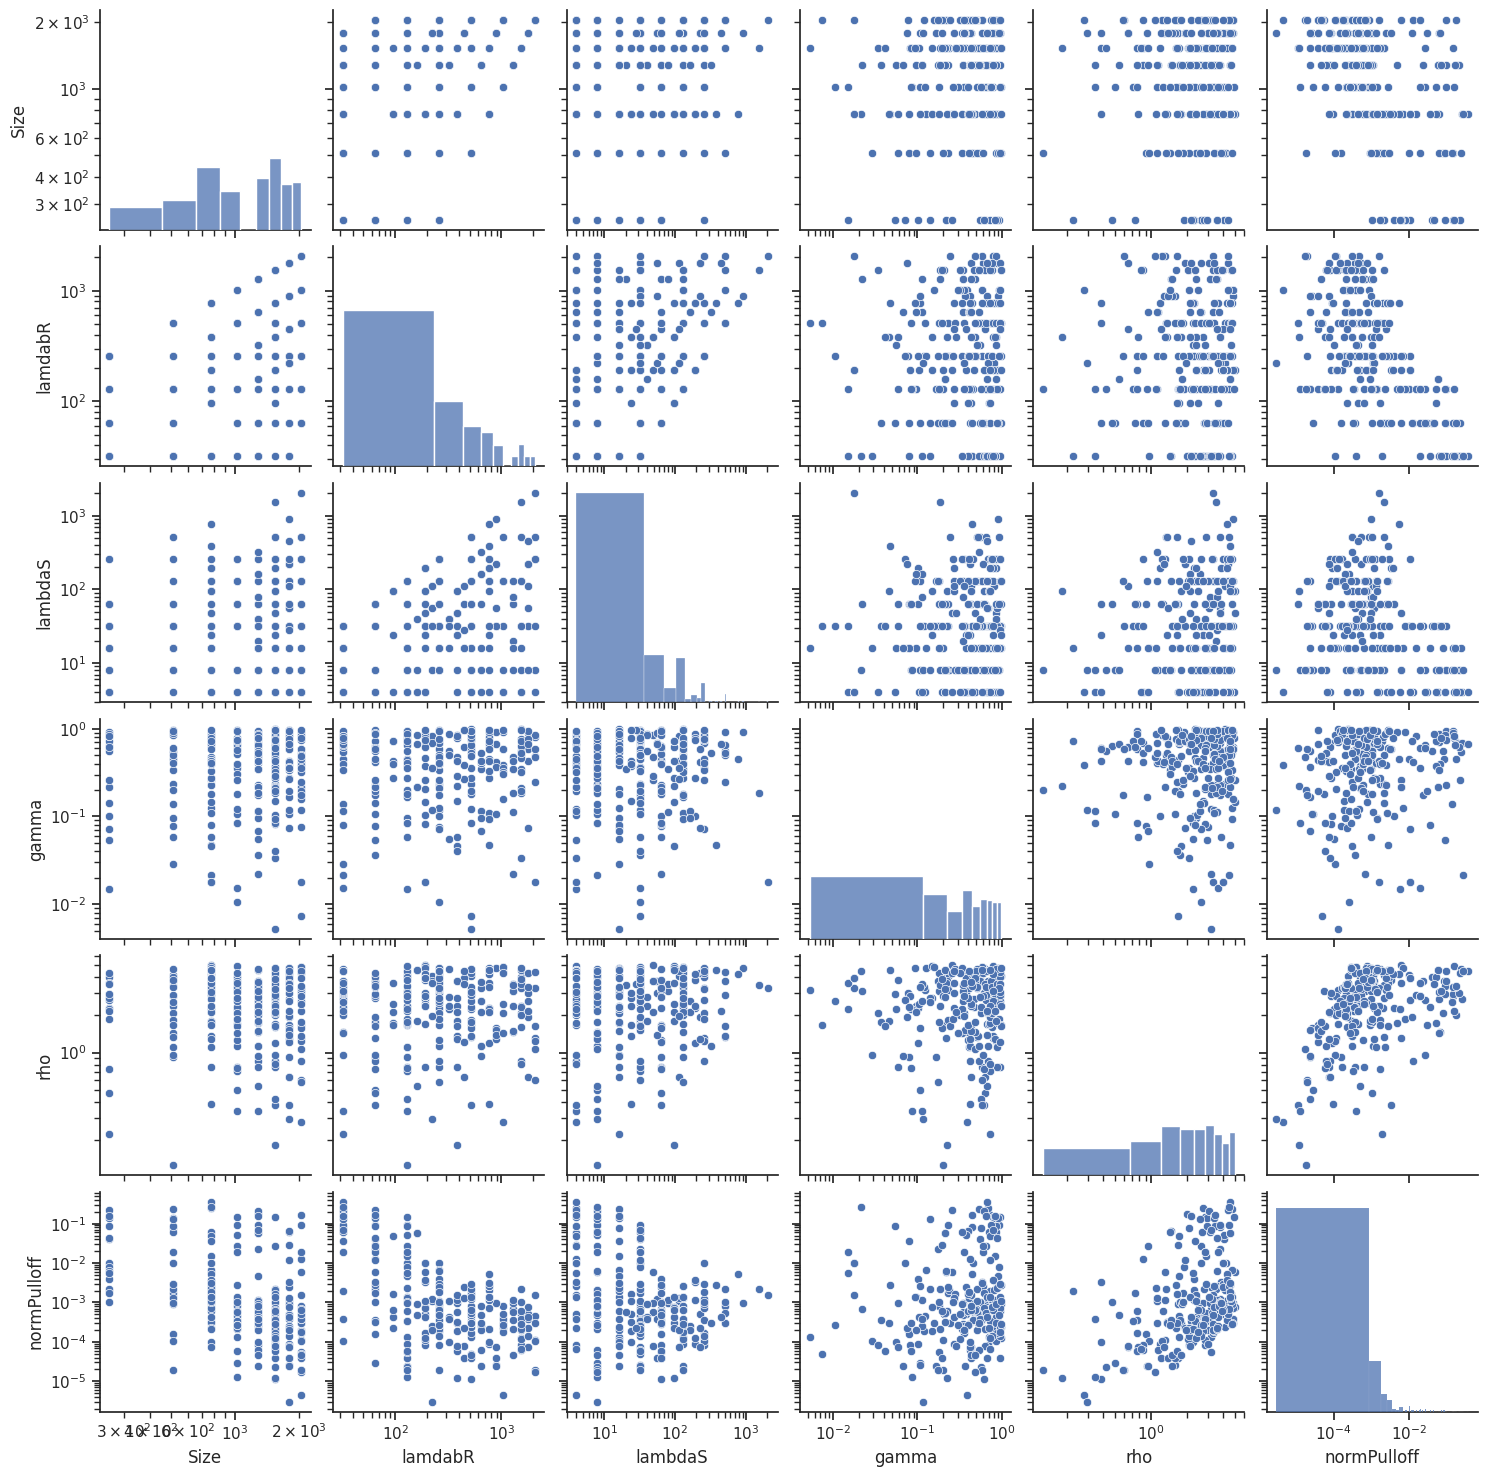

In [6]:
sns.set_theme(style="ticks")
pl = sns.pairplot(dataset)

for ax in pl.axes.flat:
    ax.set(xscale='log')
    ax.set(yscale='log')

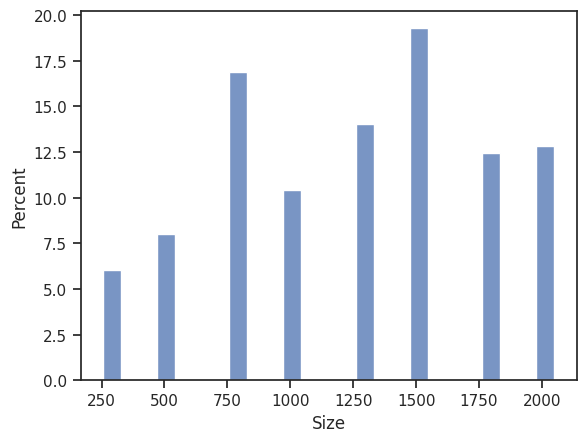

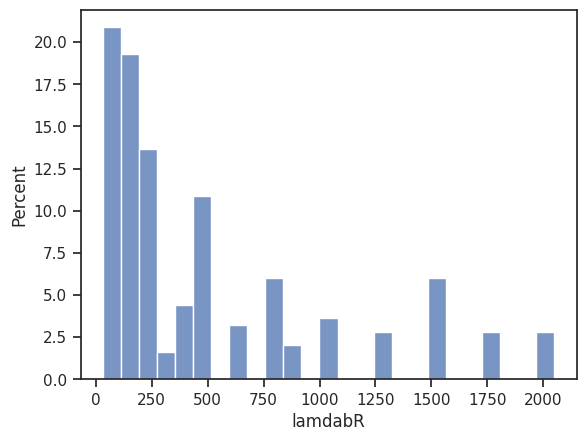

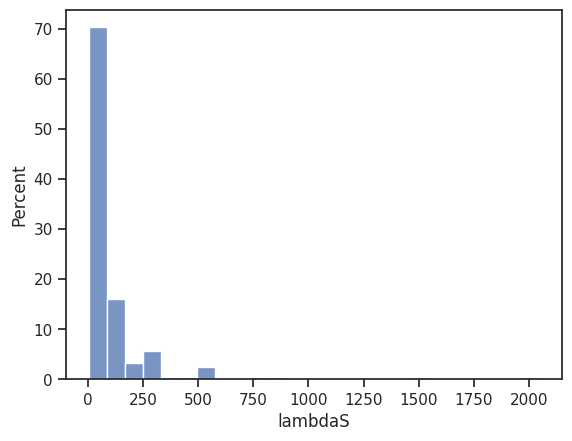

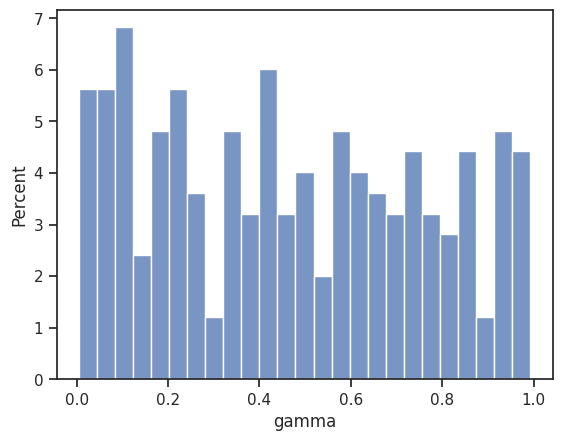

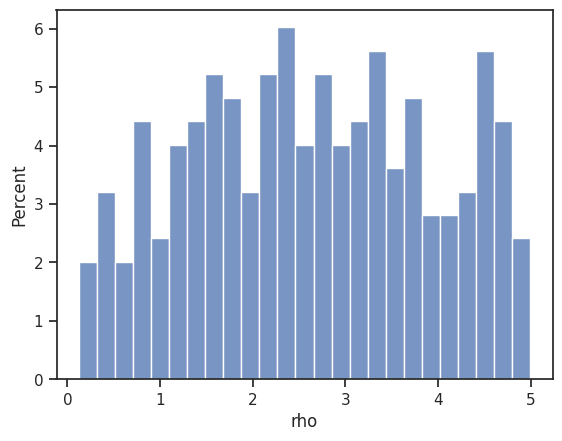

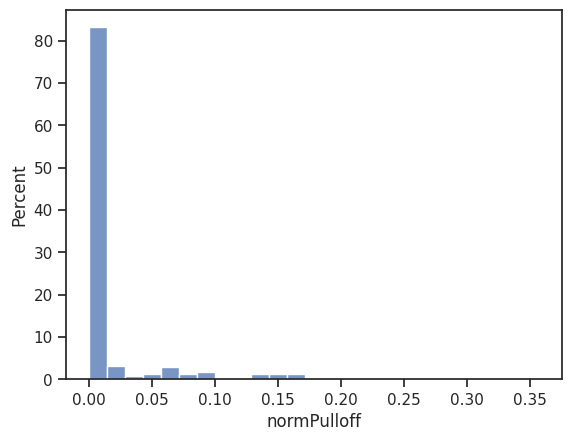

In [7]:
for col in dataset.columns:
    sns.histplot(data=dataset, x=col, stat='percent', bins=25)
    plt.show()

In [8]:
num_samples = len(dataset) - 20

train_dataset = dataset.take(range(0,num_samples))
test_dataset = dataset.drop(train_dataset.index)

test_dataset.sort_values('gamma', inplace=True)

len(train_dataset)

229

In [104]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = list(train_features.pop('normPulloff'))
test_labels = list(test_features.pop('normPulloff'))

In [140]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

rng = np.random.RandomState()

ada_regr = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=12), n_estimators=300, learning_rate=.2 , loss='linear', random_state=rng
)

ada_regr.fit(train_dataset.drop(['normPulloff'], axis=1), train_labels)

preds = ada_regr.predict(test_dataset.drop(['normPulloff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0001177606
Root Mean squared error: 0.0108517576
Mean absolute error: 0.0044408995
Coefficient of determination: 0.90822


[]

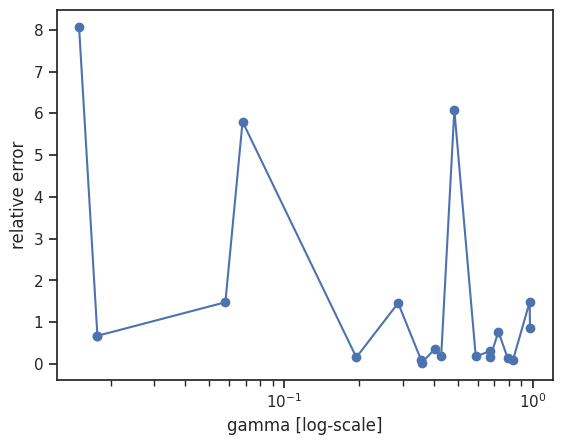

In [141]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i] - preds[i]) / test_labels[i]
    chi.append(curr)

plt.plot(test_dataset['gamma'], chi, marker='o', label='Chi Square')
plt.xscale('log')
plt.xlabel('gamma [log-scale]')
plt.ylabel('relative error')
plt.plot()

[]

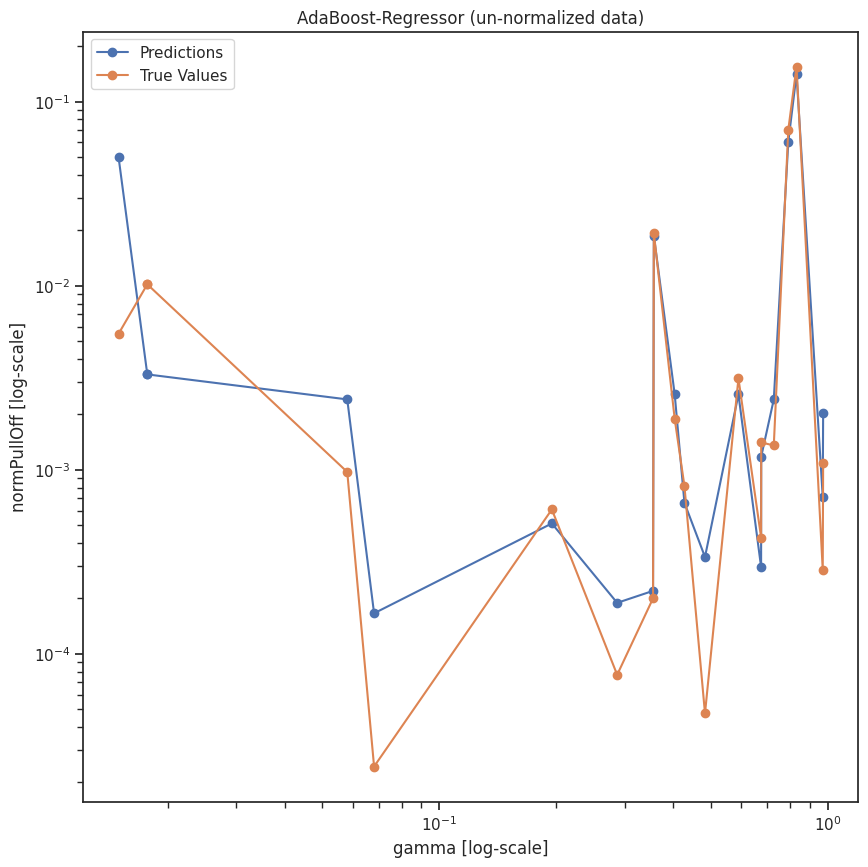

In [142]:
plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["gamma"], preds, ls='-', marker='o', label='Predictions')
plt.plot(test_features["gamma"], test_labels, ls='-', marker='o', label='True Values')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("AdaBoost-Regressor (un-normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [114]:
from sklearn.ensemble import RandomForestRegressor

randForestReg = RandomForestRegressor(n_estimators=500, criterion="absolute_error")
randForestReg.fit(train_dataset.drop(['normPulloff'], axis=1), train_labels)

preds = randForestReg.predict(test_dataset.drop(['normPulloff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0002002406
Root Mean squared error: 0.0141506405
Mean absolute error: 0.0079417125
Coefficient of determination: 0.84393


[]

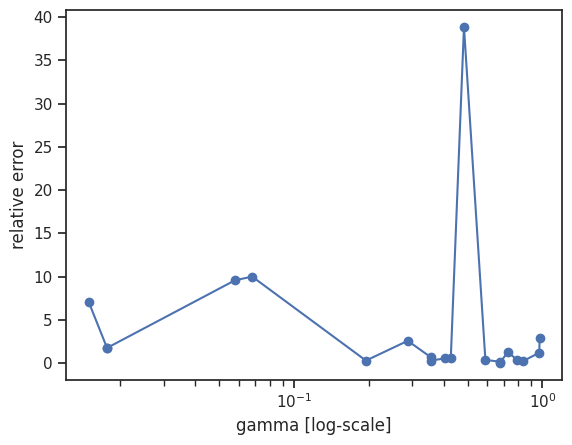

In [115]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i] - preds[i]) / test_labels[i]
    chi.append(curr)

plt.plot(test_dataset['gamma'], chi, marker='o', label='Chi Square')
plt.xscale('log')
plt.xlabel('gamma [log-scale]')
plt.ylabel('relative error')
plt.plot()

[]

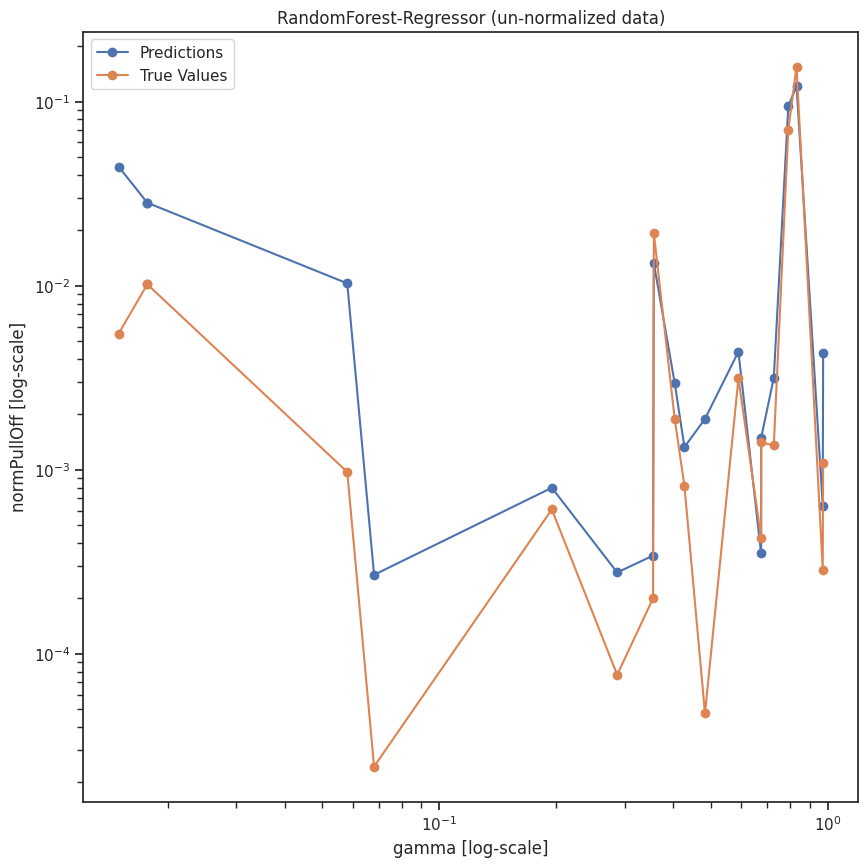

In [116]:
plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["gamma"], preds, marker='o', label='Predictions')
plt.plot(test_features["gamma"], test_labels, marker='o', label='True Values')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("RandomForest-Regressor (un-normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [117]:
from sklearn.ensemble import GradientBoostingRegressor

grb = GradientBoostingRegressor(
    loss='huber',
    learning_rate=0.1,
    subsample=.9,
    n_estimators=500,
    max_depth=3,
    criterion='friedman_mse',
    alpha=0.8,
    warm_start=True,
)

grb.fit(train_dataset.drop(['normPulloff'], axis=1), train_labels)

preds = grb.predict(test_dataset.drop(['normPulloff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0001028692
Root Mean squared error: 0.0101424442
Mean absolute error: 0.0051780257
Coefficient of determination: 0.91982


[]

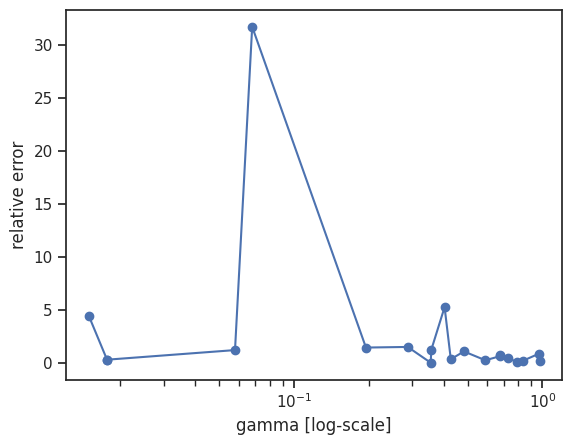

In [118]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i] - preds[i]) / test_labels[i]
    chi.append(curr)

plt.plot(test_dataset['gamma'], chi, marker='o', label='Chi Square')
plt.xscale('log')
plt.xlabel('gamma [log-scale]')
plt.ylabel('relative error')
plt.plot()

[]

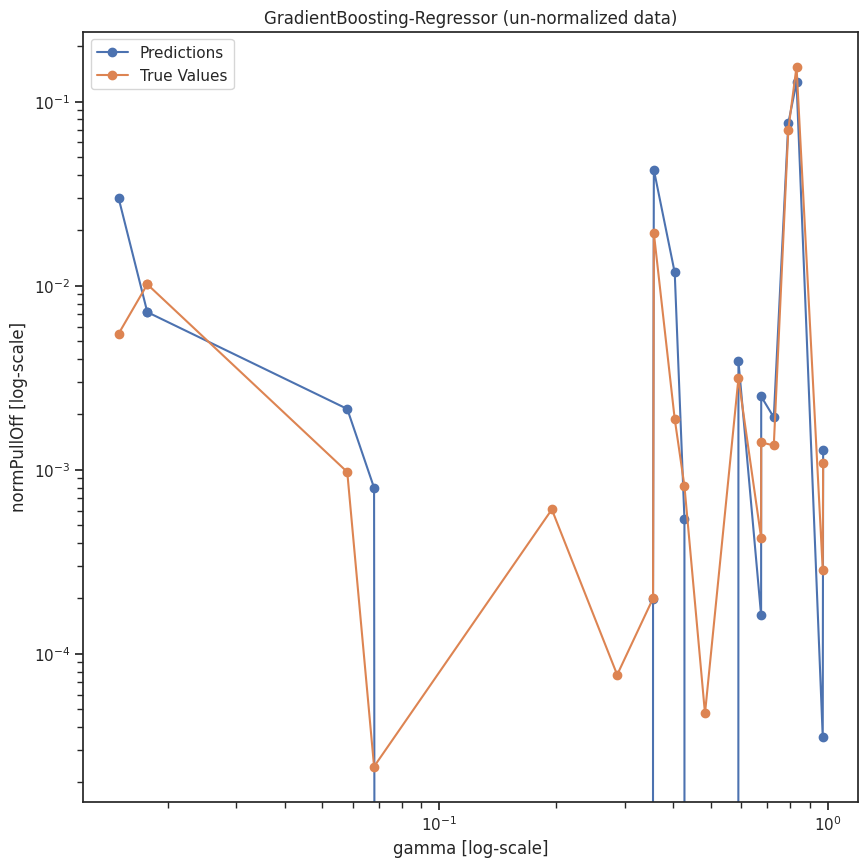

In [119]:
plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["gamma"], preds, marker='o', label='Predictions')
plt.plot(test_features["gamma"], test_labels, marker='o', label='True Values')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("GradientBoosting-Regressor (un-normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [120]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=7, weights='distance', p=2)
knn_reg.fit(train_dataset.drop(['normPulloff'], axis=1), train_labels)

preds = knn_reg.predict(test_dataset.drop(['normPulloff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0007100026
Root Mean squared error: 0.0266458748
Mean absolute error: 0.0130997157
Coefficient of determination: 0.44663


[]

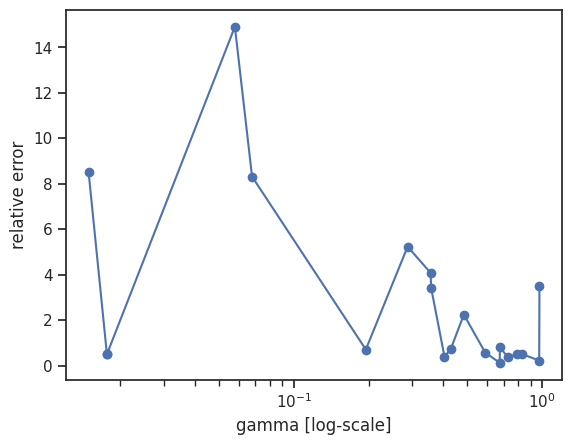

In [121]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i] - preds[i]) / test_labels[i]
    chi.append(curr)

plt.plot(test_dataset['gamma'], chi, marker='o', label='Chi Square')
plt.xscale('log')
plt.xlabel('gamma [log-scale]')
plt.ylabel('relative error')
plt.plot()

[]

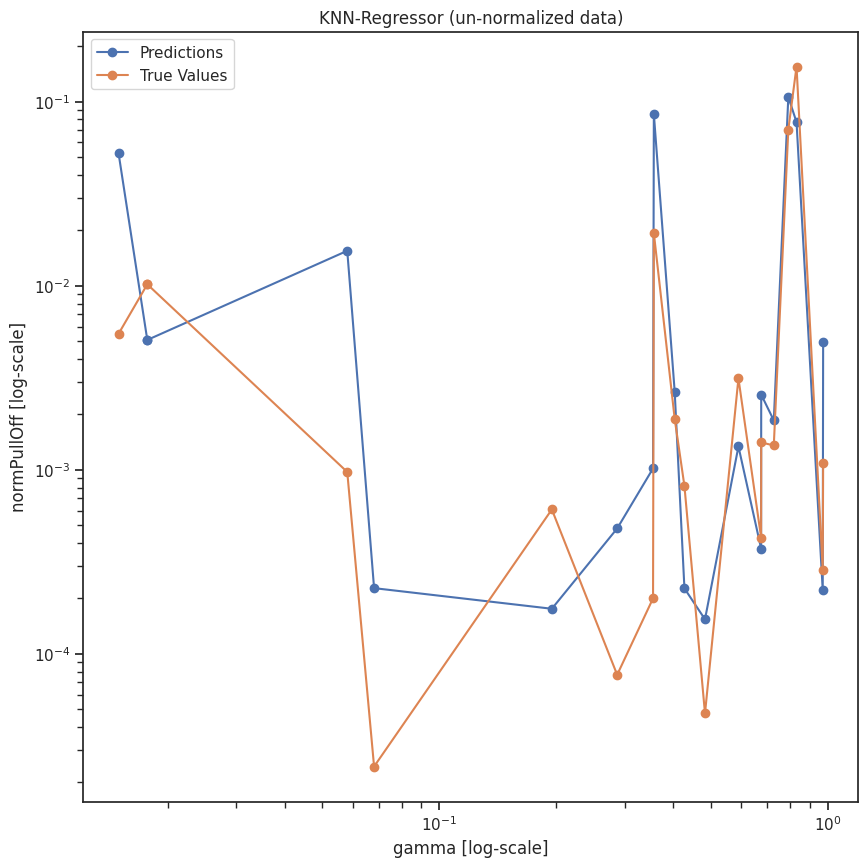

In [122]:
plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["gamma"], preds, marker='o', label='Predictions')
plt.plot(test_features["gamma"], test_labels, marker='o', label='True Values')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("KNN-Regressor (un-normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [134]:
from sklearn.ensemble import VotingRegressor

rng = np.random.RandomState()

randForestReg = RandomForestRegressor(n_estimators=500, criterion="squared_error")
knn_reg = KNeighborsRegressor(n_neighbors=7, weights='distance', p=2)
grb = GradientBoostingRegressor(
    loss='huber',
    learning_rate=0.1,
    subsample=.9,
    n_estimators=500,
    max_depth=3,
    criterion='friedman_mse',
    alpha=0.8,
    warm_start=True,
)
ada_regr = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=12), n_estimators=300, learning_rate=.2, loss='square', random_state=rng
)

ereg = VotingRegressor(estimators=[('ada', ada_regr), ('grb', grb), ('knn', knn_reg), ('RF', randForestReg)])
ereg = ereg.fit(train_dataset.drop(['normPulloff'], axis=1), train_labels)

preds = ereg.predict(test_dataset.drop(['normPulloff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0001736068
Root Mean squared error: 0.0131759937
Mean absolute error: 0.0064390679
Coefficient of determination: 0.86469


[]

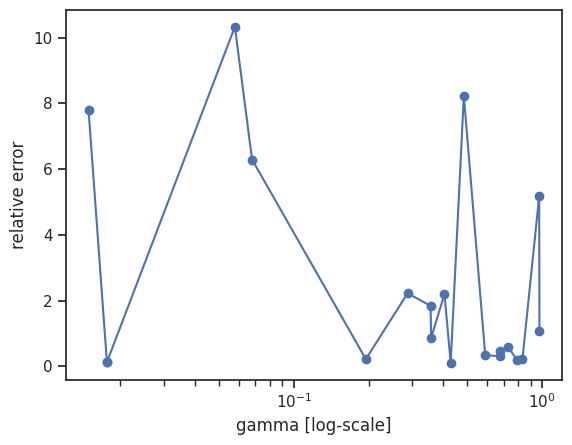

In [135]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i] - preds[i]) / test_labels[i]
    chi.append(curr)

plt.plot(test_dataset['gamma'], chi, marker='o', label='Chi Square')
plt.xscale('log')
plt.xlabel('gamma [log-scale]')
plt.ylabel('relative error')
plt.plot()

[]

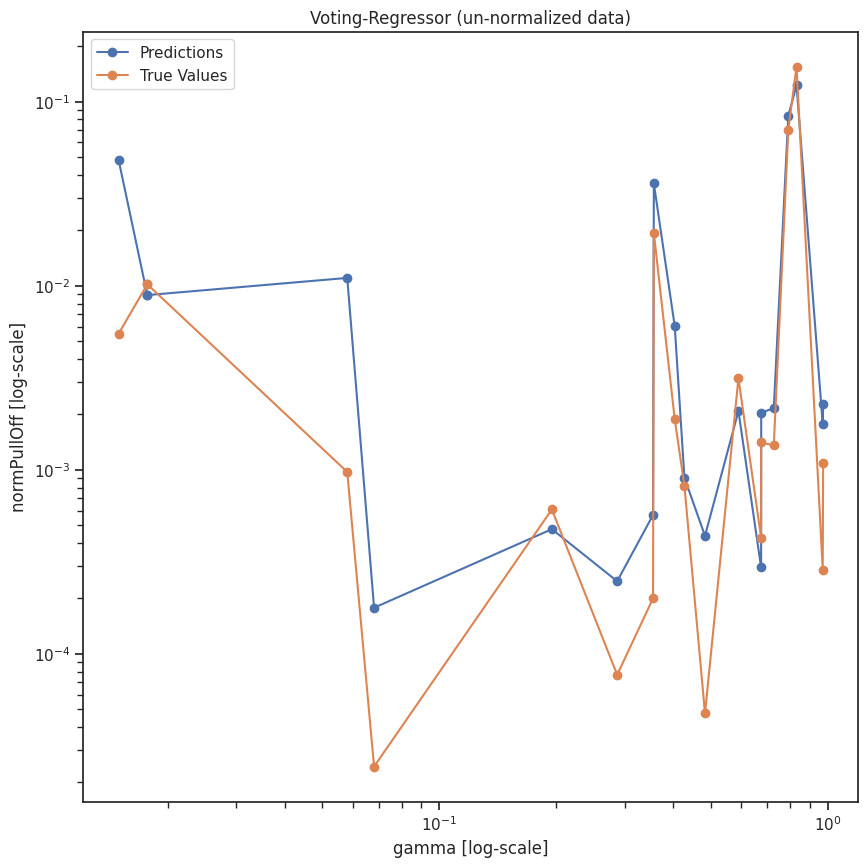

In [136]:
plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["gamma"], preds, marker='o', label='Predictions')
plt.plot(test_features["gamma"], test_labels, marker='o', label='True Values')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("Voting-Regressor (un-normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [132]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Size,1266.585153,529.489681
lamdabR,506.270742,540.636285
lambdaS,97.048035,203.613373
gamma,0.467093,0.293588
rho,2.595038,1.317621
normPulloff,0.018764,0.051139


In [133]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[1.2665851e+03 5.0627069e+02 9.7048042e+01 4.6709290e-01 2.5950382e+00]]


In [95]:
def loss(y_true, y_pred):
  #mse = keras.losses.mean_squared_error(y_true, y_pred)
  mae = keras.losses.mean_absolute_error(y_true, y_pred)
  return mae

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64),
      layers.LayerNormalization(),
      layers.Dropout(0.5),
      layers.ReLU(),
      layers.Dense(1)
  ])

  model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(1e-2))
  return model

In [96]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                384       
                                                                 
 layer_normalization (LayerN  (None, 64)               128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [97]:
batch_size = len(train_dataset) - (int) (len(train_dataset) * 0.2)

history = dnn_model.fit(
    train_features,
    pd.DataFrame(train_labels),
    batch_size=batch_size,
    validation_split=0.2,
    epochs=2000)

Epoch 1/2000
1/1 [==============================] - 1s 955ms/step - loss: 1.1729 - val_loss: 0.4608
Epoch 2/2000
1/1 [==============================] - 0s 45ms/step - loss: 0.8435 - val_loss: 0.4243
Epoch 3/2000
1/1 [==============================] - 0s 41ms/step - loss: 0.7957 - val_loss: 0.5168
Epoch 4/2000
1/1 [==============================] - 0s 42ms/step - loss: 0.8329 - val_loss: 0.4998
Epoch 5/2000
1/1 [==============================] - 0s 39ms/step - loss: 0.7665 - val_loss: 0.4247
Epoch 6/2000
1/1 [==============================] - 0s 41ms/step - loss: 0.6960 - val_loss: 0.3430
Epoch 7/2000
1/1 [==============================] - 0s 43ms/step - loss: 0.5973 - val_loss: 0.3004
Epoch 8/2000
1/1 [==============================] - 0s 41ms/step - loss: 0.5478 - val_loss: 0.2965
Epoch 9/2000
1/1 [==============================] - 0s 38ms/step - loss: 0.5946 - val_loss: 0.2797
Epoch 10/2000
1/1 [==============================] - 0s 37ms/step - loss: 0.5162 - val_loss: 0.2510
Epoch 11

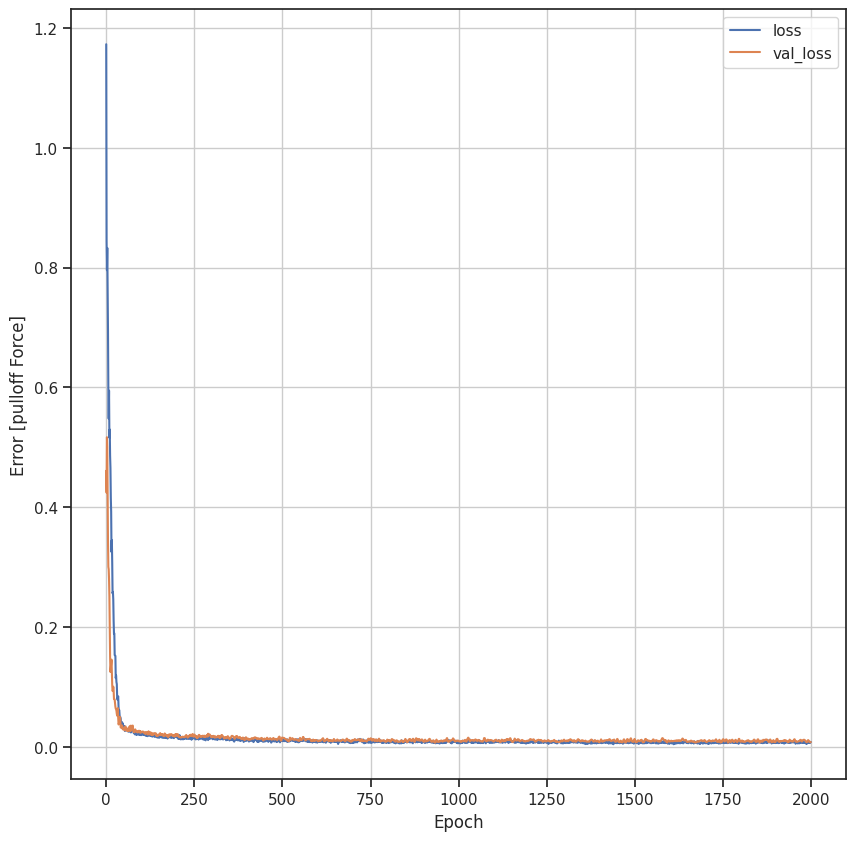

In [98]:
def plot_loss(history):
  plt.figure(figsize=(10,10))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [pulloff Force]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

1/1 [==============================] - 0s 134ms/step


[]

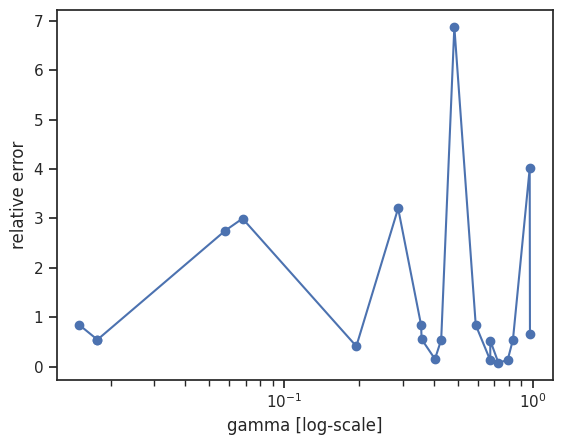

In [99]:
test_predictions = dnn_model.predict(test_features).flatten()
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i] - test_predictions[i]) / test_labels[i]
    chi.append(curr)

plt.plot(test_dataset['gamma'], chi, marker='o', label='Chi Square')
plt.xscale('log')
plt.xlabel('gamma [log-scale]')
plt.ylabel('relative error')
plt.plot()

[]

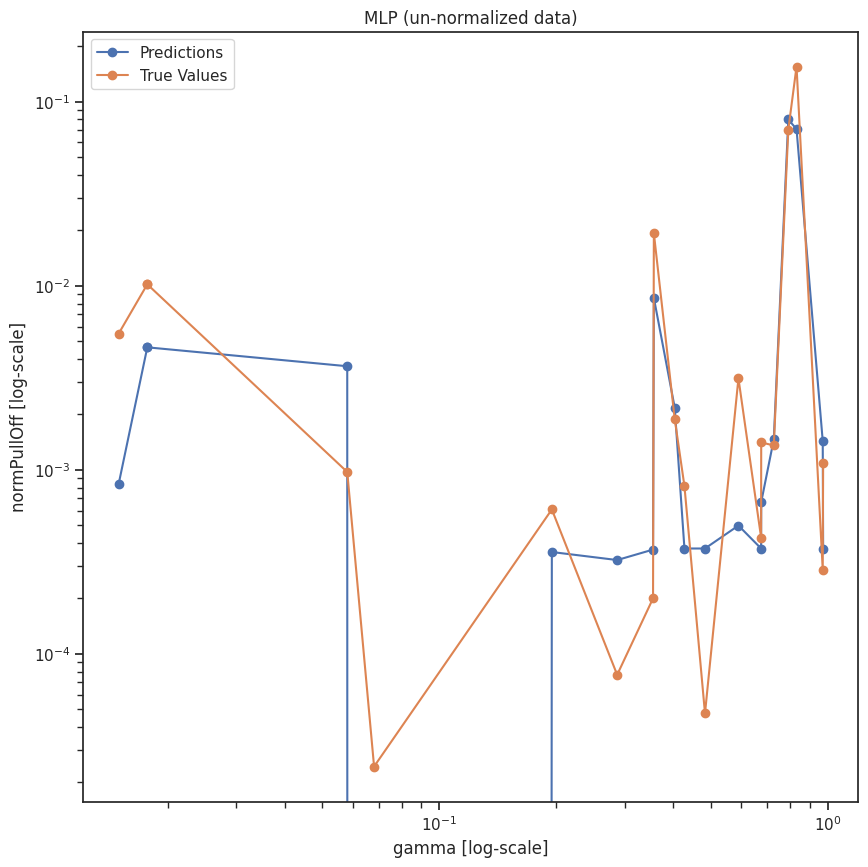

In [101]:
plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["gamma"], test_predictions, marker='o', label='Predictions')
plt.plot(test_features["gamma"], test_labels, marker='o', label='True Values')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("MLP (un-normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

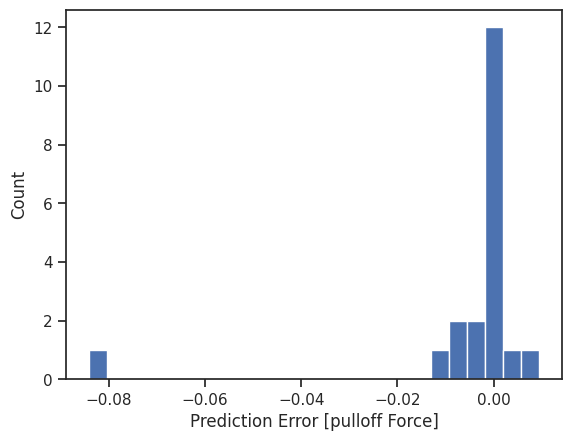

In [102]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [pulloff Force]')
_ = plt.ylabel('Count')

In [103]:
test_rsme = tf.math.sqrt(keras.losses.mean_squared_error(test_labels, test_predictions))
test_rsme.numpy()

0.019235851